In [9]:
import secml
import torch
import foolbox
from secml.array import CArray
from secml.adv.seceval import CSecEval


# Phase 1: Dataset Selection and Preprocessing

### Selected <text style="color:yellow">MNIST dataset</text>

### Importing and preprocessing dataset


In [10]:
from secml.data.loader import CDataLoaderMNIST

random_state = 42

n_tr = 3000  # no. of training set
n_val = 100  # no. of testing set
n_ts = 200

from secml.data.splitter import CTrainTestSplit

loader = CDataLoaderMNIST()
tr_data = loader.load("training", num_samples=n_tr + n_val)


splitter = CTrainTestSplit(train_size=n_tr, test_size=n_val, random_state=random_state)

tr, val = splitter.split(tr_data)
ts = loader.load("testing", num_samples=n_ts)


### Normalizing


In [11]:
tr.X = tr.X / 255
ts.X = ts.X / 255
val.X = val.X / 255


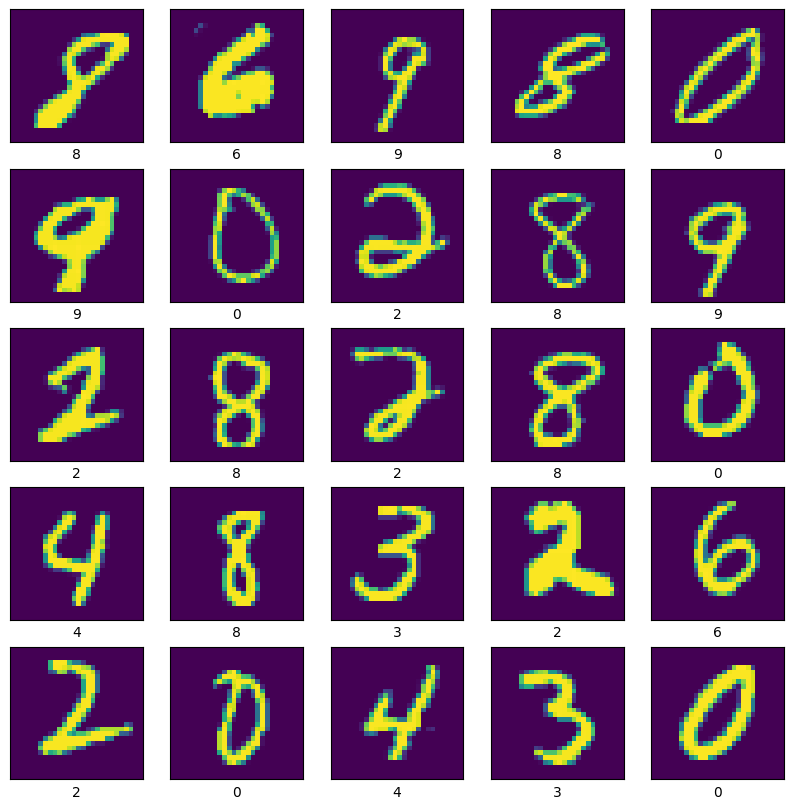

In [12]:
import matplotlib.pyplot as plt

# converting to numpy array for plotting
tr_X_array = tr.X.tondarray()
tr_Y_array = tr.Y.tondarray()


class_names = tr.Y.unique().tondarray()  # Store the class names in a list


plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_X_array[i].reshape(28, -1))
    # plt.imshow(tr_X_array[i].reshape(28, -1), cmap=plt.cm.binary)
    plt.xlabel(class_names[tr_Y_array[i]])
plt.show()
# tr_array.reshape(28, -1).shape
# tr_array[1].shape


# Phase 2: Building a Machine learning model


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    # def __init__(self):
    #     super(Net, self).__init__()
    #     self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    #     self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    #     self.conv2_drop = nn.Dropout2d()
    #     self.fc1 = nn.Linear(320, 50)
    #     self.fc2 = nn.Linear(50, 10)

    # def forward(self, x):
    #     x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
    #     x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    #     x = x.view(-1, 320)
    #     x = torch.relu(self.fc1(x))
    #     return self.fc2(x)

    # def __init__(self):
    #     super(Net, self).__init__()

    #     # Convolutional layers
    #     self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    #     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

    #     # Fully connected layers
    #     self.fc1 = nn.Linear(64 * 7 * 7, 128)
    #     self.fc2 = nn.Linear(128, 10)

    # def forward(self, x):
    #     # Convolutional layers with ReLU and Max Pooling
    #     x = F.relu(self.conv1(x))
    #     x = F.max_pool2d(F.relu(self.conv2(x)), 2)

    #     # Flatten before fully connected layers
    #     x = x.view(-1, 64 * 7 * 7)

    #     # Fully connected layers with ReLU
    #     x = F.relu(self.fc1(x))

    #     # Output layer (no activation applied here)
    #     x = self.fc2(x)

    #     return x

    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout for regularization
        self.dropout = nn.Dropout2d(p=0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = F.max_pool2d(self.dropout(x), 2)
        x = self.bn3(F.relu(self.conv3(x)))
        x = F.max_pool2d(self.dropout(x), 2)

        # Flatten before fully connected layers
        x = x.view(-1, 128 * 7 * 7)

        # Fully connected layers with batch normalization and ReLU
        x = self.fc_bn1(F.relu(self.fc1(x)))
        x = self.fc_bn2(F.relu(self.fc2(x)))

        # Output layer (no activation applied here)
        x = self.fc3(x)

        return x


In [14]:
import torch.optim as optim

net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()


# Wrapping the model in <text style="color:yellow">SecML </text>


In [15]:
from secml.ml.classifiers import CClassifierPyTorch

num_epochs = 30
clf = CClassifierPyTorch(
    model=net,
    loss=loss_function,
    optimizer=optimizer,
    epochs=num_epochs,
    batch_size=64,
    input_shape=(1, 28, 28),
    random_state=0,
)

import pickle

## saving the untrained model
filename = "model1.1.pkl"  # file name

with open(filename, "wb") as file:
    pickle.dump(clf, file)


### Loading model and training on <text style="color:yellow">clean training data</text>


In [16]:
filename = "model1.1.pkl"

# Open the file for reading binary data
with open(filename, "rb") as file:
    # loading the classifier
    not_robust = pickle.load(file)

not_robust.fit(tr.X, tr.Y)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

# Testing the model on <text style="color:yellow">clean test data</text>


In [17]:
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray

y_pred = not_robust.predict(ts.X)
peval = CMetricAccuracy()
print(
    "Model accuracy on clean set: {:.2%}".format(peval.performance_score(ts.Y, y_pred))
)


Model accuracy on clean set: 99.00%


## Phase 3 - Data Poisoning attack

## creating adversarial examples


In [18]:
# from secml.adv.attacks.evasion import CFoolboxPGDLinf

X0, Y0 = ts.X[:100, :], ts.Y[:100]

noise_type = "l2"  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = 0.0, 1.0  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # `error-specific` attack. None for `error-generic`

# Should be chosen depending on the optimization problem
solve_params = {
    "eta": 1e-1,  # is equivalent to 0.1
    "eta_min": 0.1,
    "eta_max": None,
    "max_iter": 100,
    "eps": 1e-4,  # is equivalent to 0.00001
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS

pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=not_robust,
    double_init_ds=tr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb,
    ub=ub,
    solver_params=solve_params,
    y_target=y_target,
)
pgd_pred, _, pgd_ds, _ = pgd_ls_attack.run(X0, Y0)


## Visualizing the <text style="color:yellow">adversarial examples</text> with the <text style="color:green">true labels</text> and <text style="color:red">adversarial attack labels</text> in bracket


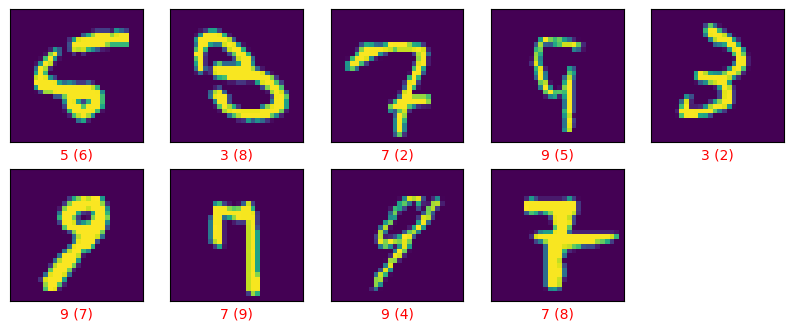

In [19]:
import matplotlib.pyplot as plt
import random

ts_X_array = X0.tondarray()
ts_Y_array = Y0.tondarray()
y_pred_array = pgd_pred.tondarray()
count = 0

plt.figure(figsize=(10, 10))
for i in range(X0.shape[0]):
    if Y0[i].item() != y_pred_array[i].item() and count < 10:
        count += 1
        rand_index = random.randint(0, X0.shape[0] - 1)  # pick a random number as index
        plt.subplot(5, 5, count)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(ts_X_array[i].reshape(28, -1))
        # plt.imshow(tr_X_array[i].reshape(28, -1), cmap=plt.cm.binary)
        plt.xlabel(
            "{} ({})".format(Y0[i].item(), y_pred_array[i].item()),
            color=("green" if Y0[i].item() == y_pred_array[i].item() else "red"),
        )

plt.show()


## Adding adversarial examples to the training set


In [20]:
tr_poisoned = tr.append(pgd_ds)
tr_poisoned.X.shape


(3100, 784)

# comparing normal model and attacked model on clean and poisoned test set


In [21]:
n_poisoning_points = 50
pgd_ls_attack.n_points = n_poisoning_points


In [22]:
from secml.ml.peval.metrics import CMetricAccuracy

metric = CMetricAccuracy()

print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pgd_ls_attack.run(ts.X, ts.Y)
print("Attack complete!")

acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))


Attack started...
Attack complete!
Original accuracy on test set: 99.00%
Accuracy after attack on test set: 90.00%


## adding <text style="color:red">adversarial examples</text> to the training copy (poisoning)


In [23]:
tr_poisoned = tr.append(pgd_ds)
tr_poisoned.X.shape


(3100, 784)

# Phase 4 - Retrain the model on the poisoned dataset.


#### training model on poisoned dataset


In [24]:
# with open(filename, "rb") as file:
#     # Use pickle to load the classifier
#     robust_model = pickle.load(file)


robust_model = not_robust.deepcopy()
robust_model.fit(tr_poisoned.X, tr_poisoned.Y)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

## prediction of robust model on <text style="color:green"> clean dataset</text>


In [25]:
y_pred_robust = robust_model.predict(ts.X)


#### Robust model attack


In [26]:
robust_attack = CAttackEvasionPGDLS(
    classifier=robust_model,
    double_init_ds=tr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb,
    ub=ub,
    solver_params=solve_params,
    y_target=y_target,
)


## prediction of robust model on <text style="color:red">poisoned dataset</text>


In [27]:
print("Attack started....")
robust_pred, _, pgd_ds_robust, _ = robust_attack.run(ts.X, ts.Y)
print("Attack ended....")

# Comparing accuracies
robust_acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred_robust)
robust_pois_acc = metric.performance_score(y_true=ts.Y, y_pred=robust_pred)
print(
    "Accuracy of robust model on clean test set before attack: {:.2%}".format(
        robust_acc
    )
)
print(
    "Accuracy of robust model on poisoned test set after attack: {:.2%}".format(
        robust_pois_acc
    )
)


Attack started....
Attack ended....
Accuracy of robust model on clean test set before attack: 99.50%
Accuracy of robust model on poisoned test set after attack: 96.00%


## Phase 5 - evaluation


#### Crafting advasarial with the same attack in phase 3


In [28]:
# this time i will create examples from the last 50 items in the dataset

X0, Y0 = X0, Y0 = ts.X[150:, :], ts.Y[150:]


noise_type = "l2"  # Type of perturbation 'l2'
dmax = 0.6  # Maximum perturbation
lb, ub = 0.0, 1.0  # Bounds of the attack space.
y_target = None


pgd_ls_not_rubust = CAttackEvasionPGDLS(
    classifier=not_robust,
    double_init_ds=tr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb,
    ub=ub,
    solver_params=solve_params,
    y_target=y_target,
)

pgd_ls_rubust = CAttackEvasionPGDLS(
    classifier=robust_model,
    double_init_ds=tr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb,
    ub=ub,
    solver_params=solve_params,
    y_target=y_target,
)
# pgd_pred, _, pgd_ds, _ = pgd_ls_attack.run(X0, Y0)


## Testing Model robustness


In [29]:
dmax_vals = CArray.linspace(0, stop=0.4, num=10)

sec_eval_not_robust = CSecEval(
    attack=pgd_ls_not_rubust, param_name="dmax", param_values=dmax_vals
)

sec_eval_robust = CSecEval(
    attack=pgd_ls_rubust, param_name="dmax", param_values=dmax_vals
)
sec_eval_not_robust.run_sec_eval(ts)
sec_eval_robust.run_sec_eval(ts)


## Accuracy begins to dip for unrobust model before the Robust model


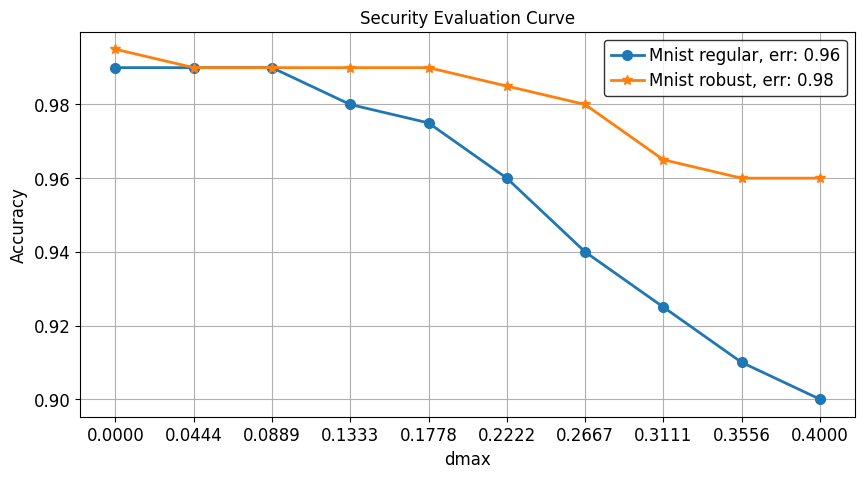

In [30]:
%matplotlib inline

from secml.figure import CFigure

fig = CFigure(height=5, width=10)

fig.sp.plot_sec_eval(sec_eval_not_robust.sec_eval_data, marker='o',
                     label="Mnist regular", show_average=True)

fig.sp.plot_sec_eval(sec_eval_robust.sec_eval_data, marker='*',
                     label="Mnist robust", show_average=True)


In [31]:
## performing predictions
y_pred_not_robust, _, adv_ds_not_robust, _ = pgd_ls_not_rubust.run(X0, Y0)
y_pred_robust, _, adv_ds_robust, _ = pgd_ls_rubust.run(X0, Y0)


In [32]:
# let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, n_display=8, title=None):
    digits = list(range(10))
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display * 2, height=4)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx + 1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap="gray")
        fig.sp.title(
            "{} ({})".format(digits[labels[idx].item()], digits[preds[idx].item()]),
            color=("green" if labels[idx].item() == preds[idx].item() else "red"),
        )
    if title is not None:
        fig.title(title)
    fig.show()


In [33]:
not_robust_acc = metric.performance_score(y_true=Y0, y_pred=y_pred_not_robust)
robust_acc = metric.performance_score(y_true=Y0, y_pred=y_pred_robust)

print("Accuracy of regular model after attack: {:.2%}".format(not_robust_acc))
print("Accuracy of robust model after attack: {:.2%}".format(robust_acc))


Accuracy of regular model after attack: 88.00%
Accuracy of robust model after attack: 92.00%


## Crafting new attack (CFoolPGDLinf)


In [34]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf

X0, Y0 = ts.X[:100, :], ts.Y[100:]
y_target = None
lb, ub = 0.0, 1.0
eps = 0.3  # this will be changed by the security evaluation class
alpha = 0.05
steps = 100

pgd_linf_attack = CFoolboxPGDLinf(
    not_robust,
    y_target,
    lb=lb,
    ub=ub,
    epsilons=eps,
    abs_stepsize=alpha,
    steps=steps,
    random_start=False,
)


In [35]:
print("Attack started...")
y_linf_pred, scores, adv_linf_ds, f_obj = pgd_linf_attack.run(ts.X, ts.Y)
print("Attack complete!")


Attack started...
Attack complete!


# robust model accuracy on different attack


In [36]:
# ts_pois = ts


In [47]:
robust_acc_clean = metric.performance_score(
    y_true=ts.Y, y_pred=robust_model.predict(ts.X)
)  # robust acc on clean test dataset
robust_acc_poisoned = metric.performance_score(
    y_true=ts.Y, y_pred=robust_model.predict(adv_linf_ds.X)
)
print("accuracy of robust model on clean test data: {} ".format(robust_acc_clean))
print("accuracy of robust model on poisoned test data: {} ".format(robust_acc_poisoned))
# robust_acc_clean, robust_acc_poisoned


accuracy of robust model on clean test data: 0.995 
accuracy of robust model on poisoned test data: 0.0 


: 

## The second attack is effective on the robust model because it's not trained on the second attack


<h1> Part 2 : Deep Neural Rejection against Adversarial
Examples with SVM</h1>


## Phase 1


In [38]:
from secml.model_zoo import load_model

dnn = load_model("mnist-cnn")



File stored in `C:\Users\mbele\secml-data\models\models_dict.json`


In [39]:
from secml.ml.classifiers import CClassifierSVM

from secml.ml.kernels import CKernelRBF
from secml.ml.classifiers.reject import CClassifierDNR


In [40]:
layers = ["features:relu2", "features:relu3", "features:relu4"]
combiner = CClassifierSVM(kernel=CKernelRBF(gamma=1), C=0.1)
layer_clf = CClassifierSVM(kernel=CKernelRBF(gamma=1e-2), C=10)


In [41]:
dnr = CClassifierDNR(
    combiner=combiner, layer_clf=layer_clf, dnn=dnn, layers=layers, threshold=-1000
)


dnr.set_params({"features:relu4.C": 1, "features:relu2.kernel.gamma": 1e-3})


In [42]:
print("Training started...")
dnr.fit(x=tr.X, y=tr.Y)
print("Training completed.")


Training started...
Training completed.


In [43]:
print("Computing reject threshold...")
dnr.threshold = dnr.compute_threshold(rej_percent=0.1, ds=ts)


Computing reject threshold...


## Attacking DNR


In [44]:
from secml.adv.attacks import CAttackEvasionPGDExp

solver_params = {"eta": 1e-1, "eta_min": 1e-1, "max_iter": 30, "eps": 1e-8}

pgd_exp = CAttackEvasionPGDExp(
    classifier=dnr,
    double_init_ds=ts,
    dmax=2,
    distance="l2",
    solver_params=solver_params,
)

sample_idx = 10
print("Running attack...")
_ = pgd_exp.run(x=ts[sample_idx, :].X, y=ts[sample_idx, :].Y)
print("Attack completed.")


Running attack...
Attack completed.


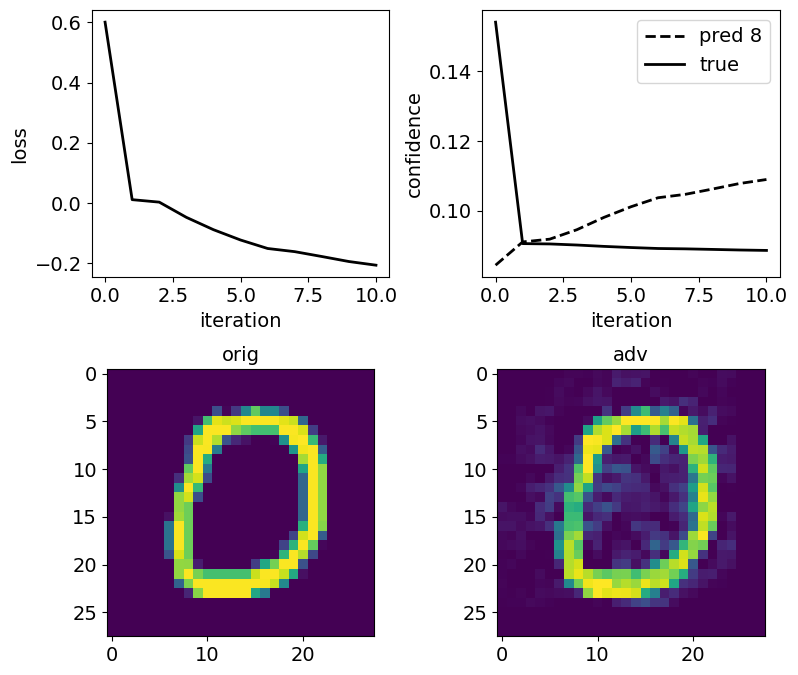

In [45]:
from secml.figure import CFigure
from secml.ml.classifiers.loss import CSoftmax


def plot_loss_img(attack, clf, sample_idx):
    n_iter = attack.x_seq.shape[0]
    itrs = CArray.arange(n_iter)
    true_class = ts.Y[sample_idx]
    fig = CFigure(width=8, height=7, fontsize=14, linewidth=2)

    fig.subplot(2, 2, 1)
    loss = attack.f_seq
    fig.sp.xlabel('iteration')
    fig.sp.ylabel('loss')
    fig.sp.plot(itrs, loss, c='black')
    pred_classes, scores = clf.predict(attack.x_seq,
                                       return_decision_function=True)
    scores = CSoftmax().softmax(scores)

    fig.subplot(2, 2, 2)
    fig.sp.xlabel('iteration')
    fig.sp.ylabel('confidence')
    fig.sp.plot(itrs, scores[:, pred_classes[-1].item()], linestyle='--',
                c='black', label='pred {:}'.format(pred_classes[-1].item()))
    fig.sp.plot(itrs, scores[:, true_class], c='black', label='true')
    fig.sp.legend()

    fig.subplot(2, 2, 3)
    fig.sp.title('orig')
    fig.sp.imshow(ts.X[sample_idx, :].tondarray().reshape((28, 28)))

    fig.subplot(2, 2, 4)
    fig.sp.title('adv')
    fig.sp.imshow(attack.x_seq[-1, :].tondarray().reshape((28, 28)))

    fig.tight_layout()
    fig.show()

# Only required for visualization in notebooks
%matplotlib inline
plot_loss_img(pgd_exp, dnr, sample_idx)
